In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, tqdm
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

## Process images for a single patient

- load SITK images from NIFTI files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [7]:
%autoreload
patient = mre_pinn.data.Patient(
    nifti_dir='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0006',
    sequences=[
        't1_pre_in', 't1_pre_out', 't1_pre_water', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre'
    ],
    xarray_dir='../data/NAFLD_test/'
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [9]:
%autoreload
patient.preprocess_images()

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_in to mre_raw
ParameterObject (0x55e7fd274cb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 243971
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2

In [10]:
patient.metadata

size    spacing      origin       limit     center  \
sequence     dimension                                                       
t1_pre_in    0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_out   0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_water 0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_fat   0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t2           0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2            23  10.000000  -94.556400  125.443600  15.443600   
mre_raw      0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
wave         0           512   0.703150 -207.255582  152.054055 -27.600763   
             1           512   0.703150 -196.210569  163.099068 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
mre          0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2           44.000000  
wave         0          360.012787  
             1          360.012787  
             2           44.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

Converting t1_pre_in to xarray
Converting t1_pre_out to xarray
Converting t1_pre_water to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray


<IPython.core.display.Javascript object>


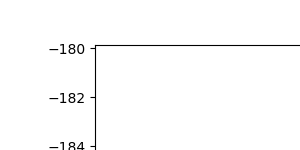

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [11]:
%autoreload
patient.view(compare=True)

In [ ]:
%autoreload
patient.save_xarrays()

In [ ]:
patient.load_xarrays()

## Process images for a patient cohort

In [ ]:
%ls /ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI/ -d

In [ ]:
%cat /ocean/projects/asc170022p/shared/Data/MRE/gold.txt

In [3]:
with open('/ocean/projects/asc170022p/shared/Data/MRE/gold.txt') as f:
    patient_ids = [line.split('.')[0].split('_')[1] for line in f]

len(patient_ids)

181

In [4]:
%autoreload
cohort = mre_pinn.data.PatientCohort(
    nifti_dirs='/ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI',
    patient_ids='{' + ','.join(patient_ids) + '}',
    xarray_dir='../data/NAFLD/'
)
len(cohort)

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0830 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0838 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0846 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0860 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0872 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1474 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1483 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1495 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1504 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1526 

155

In [5]:
%%time
cohort.load_images()

  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
  1%|          | 1/155 [00:01<03:13,  1.26s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0900/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre.nii
  7%|▋         | 11/155 [00:12<02:33,  1.06s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/mre_raw.nii
Loading /ocean/projects/as

 14%|█▎        | 21/155 [00:22<02:15,  1.01s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre.nii
 14%|█▍        | 22/155 [00:24<02:45,  1.24s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1108/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre.nii
 21%|██        | 32/155 [00:35<02:08,  1.04s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t2.nii
Loading /ocean/projects

 27%|██▋       | 42/155 [00:46<01:55,  1.03s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre.nii
 28%|██▊       | 43/155 [00:47<01:52,  1.00s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1343/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre.nii
 34%|███▍      | 53/155 [00:58<02:04,  1.22s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t2.nii
Loading /ocean/projects

 41%|████      | 63/155 [01:08<01:37,  1.06s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre.nii
 41%|████▏     | 64/155 [01:09<01:36,  1.06s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre.nii
 48%|████▊     | 74/155 [01:19<01:20,  1.01it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 54%|█████▍    | 84/155 [01:30<01:15,  1.06s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre.nii
 55%|█████▍    | 85/155 [01:30<01:10,  1.01s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0457/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre.nii
 61%|██████▏   | 95/155 [01:40<00:52,  1.14it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 68%|██████▊   | 105/155 [01:52<00:57,  1.15s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre.nii
 68%|██████▊   | 106/155 [01:53<00:53,  1.08s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0704/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre.nii
 75%|███████▍  | 116/155 [02:02<00:37,  1.05it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/mre_raw.nii
Loading /ocean/projects/asc170022p/

 81%|████████▏ | 126/155 [02:15<00:32,  1.10s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre.nii
 82%|████████▏ | 127/155 [02:16<00:31,  1.11s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1785/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre.nii
 88%|████████▊ | 137/155 [02:27<00:18,  1.00s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t2.nii
Loading /ocean/projects/asc17002

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1935/mre.nii
 95%|█████████▍| 147/155 [02:39<00:09,  1.17s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre.nii
 95%|█████████▌| 148/155 [02:40<00:07,  1.13s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/19

In [6]:
%%time
m = cohort.metadata
m

CPU times: user 2.51 s, sys: 4.28 ms, total: 2.51 s
Wall time: 2.77 s


size    spacing      origin       limit  \
patient_id sequence     dimension                                            
0898       t1_pre_in    0           512   0.820300 -193.358994  225.814298   
                        1           512   0.820300 -265.899994  153.273297   
                        2           120   2.300003  -64.173203  209.527161   
           t1_pre_water 0           512   0.820300 -193.358994  225.814298   
                        1           512   0.820300 -265.899994  153.273297   
...                                 ...        ...         ...         ...   
2046       wave         1           512   1.000000    0.000000  511.000000   
                        2             4   1.000000    0.000000    3.000000   
           mre          0           256   1.484400 -173.035995  205.486013   
                        1           256   1.484400 -209.257996  169.264013   
                        2             4  11.000000  -92.152802  -59.152802   

                                       center      extent  
patient_id sequence     dimension                          
0898       t1_pre_in    0           16.227652  419.993591  
                        1          -56.313348  419.993591  
                        2           72.676979  276.000366  
           t1_pre_water 0           16.227652  419.993591  
                        1          -56.313348  419.993591  
...                                       ...         ...  
2046       wave         1          255.500000  512.000000  
                        2            1.500000    4.000000  
           mre          0           16.225009  380.006409  
                        1          -19.996991  380.006409  
                        2          -75.652802   44.000000  

[3720 rows x 6 columns]

In [7]:
%%time
cohort.create_xarrays()

Loading segmentation model
  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557f223a4170)
  RTTI typeinfo:   elastix::ParameterObject
  Re

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

ParameterObject (0x557f23ad2c50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 754598
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -40.622 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.771 -229.883 -7.9134)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0141893 0.00312086 0.00400683 -0.647806 -0.279106 

  (TransformParameters 5.43814e-05 -8.11146e-05 -2.98969e-06 0.0241137 0.0061716 -0.0857737)
  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e6794f590)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 961971
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.1432 -20.0002 129.457)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.765 -219.622 1.80725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557f23ada0e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1169720
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.7098 -19.9938 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194 -199.284 -41.3425)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 6.32499)
  (Transform "EulerTransform")
  (TransformParameters 6.40527e-05

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557f240fee10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1377600
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -37.9233 -22.5813 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.555 -212.213 -85.8186)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.00096

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e67904370)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1585332
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -41.8383 28.0817 110.295)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.516 -141.596 1.04483)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.6641 0.6641 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.104772 0.00

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e6a564220)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1792937
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.663 -24.294 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -169.598 -213.555 -78.6155)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 6.90001)
  (Transform "EulerTransform")
  (Transfor

Registering t1_pre_out to mre_raw
ParameterObject (0x557e6a4d5790)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2000426
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.9535 -38.9105 96.2272)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.623 -258.487 -13.0228)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.0238112 -0.01

Writing ../data/NAFLD/0964/t1_pre_water.nc
Writing ../data/NAFLD/0964/t1_pre_out.nc
Writing ../data/NAFLD/0964/t1_pre_fat.nc
Writing ../data/NAFLD/0964/t2.nc
Writing ../data/NAFLD/0964/mre_raw.nc
Writing ../data/NAFLD/0964/wave.nc
Writing ../data/NAFLD/0964/mre.nc
Writing ../data/NAFLD/0964/anat_mask.nc
Writing ../data/NAFLD/0964/mre_mask.nc
  5%|▌         | 8/155 [09:05<2:35:07, 63.32s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/mre_raw.nii
Loading /ocean/projects/asc170022p/shared

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

Registering t2 to t1_pre_out
ParameterObject (0x557e6a33f750)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2689379
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.482 -238.126 -73.4616)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 26)
  (Spacing 1.5625 1.5625 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0119679 -0.008334

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e6a610460)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2897243
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.60875 -21.7222 1.6932)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.033 -201.364 -135.156)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 120)
  (Spacing 0.7031 0.7031 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.02348

ParameterObject (0x557e6a628cb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3104932
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4128 -19.9938 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -189.703 -199.284 -87.7498)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 6.32497)
  (Transform "EulerTransform")
  (TransformParameters 0.0001466 -0.000161191 -5.81502e-05 0.001573

ParameterObject (0x557e6b1c62c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3312573
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.83825 -20.0048 155.741)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.693 -259.536 37.291)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.9375 0.9375 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0517109 0.00755258 -0.00523959 3.25727 -3.6167 

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e6d4ecae0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3520215
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.962995 -28.591 250.919)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -190.595 -218.223 132.469)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0103793 0

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e6a63b9e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3727992
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -20.0002 54.976)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.042 -219.232 -43.0574)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.32474)
  (Transform "EulerTransform")
  (Transfo

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1045/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1045/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1045/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1045/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e6e3449f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3935411
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4193 -20.0002 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformPa

Writing ../data/NAFLD/1045/t1_pre_water.nc
Writing ../data/NAFLD/1045/t1_pre_out.nc
Writing ../data/NAFLD/1045/t1_pre_fat.nc
Writing ../data/NAFLD/1045/t2.nc
Writing ../data/NAFLD/1045/mre_raw.nc
Writing ../data/NAFLD/1045/wave.nc
Writing ../data/NAFLD/1045/mre.nc
Writing ../data/NAFLD/1045/anat_mask.nc
Writing ../data/NAFLD/1045/mre_mask.nc
 10%|█         | 16/155 [17:36<2:23:36, 61.99s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/mre_raw.nii
Loading /ocean/projects/asc170022p/share

Writing ../data/NAFLD/1075/t1_pre_out.nc
Writing ../data/NAFLD/1075/t1_pre_fat.nc
Writing ../data/NAFLD/1075/t2.nc
Writing ../data/NAFLD/1075/mre_raw.nc
Writing ../data/NAFLD/1075/wave.nc
Writing ../data/NAFLD/1075/mre.nc
Writing ../data/NAFLD/1075/anat_mask.nc
Writing ../data/NAFLD/1075/mre_mask.nc
 11%|█         | 17/155 [18:38<2:22:37, 62.01s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/wa

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

Registering t2 to t1_pre_out
ParameterObject (0x557e6f0a8550)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4866035
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.223 -45.776 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.924 -264.923 -63.3052)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 25)
  (Spacing 1.7188 1.7188 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0619282 -0.0118742 0

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e631eb270)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5073833
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.5188 -56.0952 83.7631)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194.068 -265.682 -54.9869)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8203 0.8203 2.5)
  (Transform "EulerTransform")
  (TransformParameters 0.0480328 -

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e6fb22270)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5281454
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -29.32 -27.513 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.467 -246.66 -27.6886)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7188 1.7188 8.05001)
  (Transform "EulerTransform")
  (TransformParameters 2.83167e-05

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e6ec75a10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5489122
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -38.7835 -38.9105 152.733)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.37 -248.497 52.683)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.00573371 0

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e71564380)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5696909
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -12.777 -60.815 86.9886)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -232.354 -280.392 -45.2497)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 116)
  (Spacing 0.8594 0.8594 2.2998)
  (Transform "EulerTransform")
  (TransformParameters -0.0970744

  (UseDirectionCosines "true")
Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e6d4face0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5904661
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -12.1382 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.37 -238.139 -55.4114)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1

 15%|█▌        | 24/155 [26:25<2:22:44, 65.38s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e71fa9960)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e729d5ce0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6559193
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -33.7438 63.57)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.627 -223.005 -46.4278)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 23)
  (Spacing 1.4844 1.4844 9.9998)
  (Transform "EulerTransform")
  (Transfor

  (TransformParameters -3.02188e-05 -8.99698e-05 8.26552e-05 -0.00320176 -0.00756982 -0.097604)
  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e73865820)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6766978
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 33.413 -23.434 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -156.219 -213.066 -70.602)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

  (UseDirectionCosines "true")
Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e71f80660)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6974840
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04649 -42.3475 6.8496)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.13 -251.524 -109.013)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 7.47501)
  (Transform "EulerTransform")
  

  (UseDirectionCosines "true")
Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e7427aea0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7182472
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.806 -19.994 240.72)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.771 -239.571 122.27)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (Tra

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e71157130)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7390039
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -20.856 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.064 -210.488 -86.0716)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0861912 -0.

  (UseDirectionCosines "true")
Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e73172580)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7597835
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.61475 -54.3732 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.477 -283.465 -77.4373)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7968 1.79

 20%|██        | 31/155 [33:48<2:08:18, 62.08s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e7566f990)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e76188780)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8252331
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 28.257 -19.997 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.004 -209.258 -1.0382)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (TransformPara

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e74608e00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8460087
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.6275 -75.8605 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.904 -315.392 68.2679)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.9375 0.9375 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.050155 -0.

ParameterObject (0x557e76faea40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8667893
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.98225 -56.0952 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.159 -265.272 -59.3902)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 6.32501)
  (Transform "EulerTransform")
  (TransformParameters 0.000160842 -5.48704e-05 -4.35521e-05 0.0060

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e772434b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8875611
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.68851 -38.2655 182.812)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -202.311 -237.888 73.562)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0193426 

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e73afc550)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9083469
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.413 -46.635 176.438)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.99 -266.212 48.788)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0095336 0.002

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e76fadc00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9291290
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.979 -19.997 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.24 -209.258 -86.3494)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 6.89996)
  (Transform "EulerTransform")
  (TransformPar

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1311/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e772453c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9498666
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -32.0312 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.806 -231.653 -52.5553)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFor

Writing ../data/NAFLD/1311/t1_pre_water.nc
Writing ../data/NAFLD/1311/t1_pre_out.nc
Writing ../data/NAFLD/1311/t1_pre_fat.nc
Writing ../data/NAFLD/1311/t2.nc
Writing ../data/NAFLD/1311/mre_raw.nc
Writing ../data/NAFLD/1311/wave.nc
Writing ../data/NAFLD/1311/mre.nc
Writing ../data/NAFLD/1311/anat_mask.nc
Writing ../data/NAFLD/1311/mre_mask.nc
 25%|██▌       | 39/155 [42:07<2:01:09, 62.67s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1230/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1230/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1230/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1230/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1230/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1230/mre_raw.nii
Loading /ocean/projects/asc170022p/share

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

ParameterObject (0x557e764273c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10187428
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.6577 -62.6802 192.48)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.489 -281.827 57.48)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 28)
  (Spacing 1.7188 1.7188 10)
  (Transform "EulerTransform")
  (TransformParameters 0.0197663 0.0602274 0.0182064 0.175255 -2.19336 -9.34

ParameterObject (0x557e7811a040)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10394905
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.631 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.001 -209.629 -37.9452)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.10817 -0.0397758 0.0332682 0.631782 -5.38114 -30

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e7811a040)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10602636
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 42.2908 -27.1613 218.262)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -146.97 -216.422 102.399)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 7.47501)
  (Transform "EulerTransform")
  (TransformParameters 8.56751e-

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e7a1b2150)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10810224
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 38.5658 -45.7823 36.9286)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.056 -245.404 -81.5208)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.0

ParameterObject (0x557e7644adc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11017846
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -44.0665 143.494)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -253.653 15.844)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0579458 0.0493703 0.0186479 -0.0178071 -7.9011

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e7644b9e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11225468
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 26.827 -48.354 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.35 -257.531 80.0555)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 7.475)
  (Transform "EulerTransform")
  (TransformPa

Registering t1_pre_out to mre_raw
ParameterObject (0x557e7c5e4ac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11432949
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 25.6747 -20.0002 80.758)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -173.947 -219.622 -46.8922)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0155535 0.0

Writing ../data/NAFLD/1395/t1_pre_water.nc
Writing ../data/NAFLD/1395/t1_pre_out.nc
Writing ../data/NAFLD/1395/t1_pre_fat.nc
Writing ../data/NAFLD/1395/t2.nc
Writing ../data/NAFLD/1395/mre_raw.nc
Writing ../data/NAFLD/1395/wave.nc
Writing ../data/NAFLD/1395/mre.nc
Writing ../data/NAFLD/1395/anat_mask.nc
Writing ../data/NAFLD/1395/mre_mask.nc
 30%|███       | 47/155 [50:55<2:00:55, 67.18s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1400/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1400/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1400/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1400/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1400/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1400/mre_raw.nii
Loading /ocean/projects/asc170022p/share

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

Registering t2 to t1_pre_out
ParameterObject (0x557e7a8794f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12122261
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 48.0167 -37.1913 151.229)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.16 -246.368 36.229)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.6406 1.6406 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0533411 -0.0226808 0

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e7d011220)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12329727
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.928 -19.997 33.491)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.704 -209.629 -66.5591)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0773829 -0.

ParameterObject (0x557e7d3c22c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12537352
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.854 -19.997 52.3978)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.115 -209.258 -63.4649)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 7.47501)
  (Transform "EulerTransform")
  (TransformParameters -4.27562e-05 -0.00013603 1.8341e-05 0.0118474

ParameterObject (0x557e801f4b50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12744942
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.502 -57.592 161.971)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -218.039 -287.133 25.1208)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 120)
  (Spacing 0.8984 0.8984 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.080862 0.00795852 -0.00847622 -1.40084 -7.83782

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e80c99820)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12952785
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.366 -19.997 24.897)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.266 -209.629 -84.3524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.0266493 

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e80995d20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13160639
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.53776 -19.9938 182.167)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.828 -199.284 57.3919)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 8.05)
  (Transform "EulerTransform")
  (Transfor

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1448/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e822d3b50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13368114
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.19301 -19.997 34.3504)

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e81770150)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13815643
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -36.3282 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.623 -235.547 -64.321)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.5625 1.5625 10)
  (Transform "EulerTransform")
  (TransformP

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e81770020)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14023211
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8125 -41.4885 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.774 -251.075 -59.1772)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0444832 

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e7d039360)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14230981
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.852 -19.998 82.9065)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.409 -209.259 -32.9562)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 7.47501)
  (Transform "EulerTransform")
  (TransformParameters -4.51038e

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e83ad1e30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14438501
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.05560

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e830bdf00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14646127
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.291 -237.669 -37.0858)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0340672 -0

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e74d18910)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14853834
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.4288 -21.7128 14.5842)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.69 -210.974 -83.4108)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 6.32226)
  (Transform "E

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0029/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e84c37d90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15060943
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (Com

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

ParameterObject (0x557e8062c140)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15507663
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.61825 -19.9938 47.2414)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.685 -199.297 -57.7586)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0938117 -0.0133685 -0.00692373 7.08808 -8.7706

  (TransformParameters 8.47469e-06 -0.000108562 7.38546e-05 0.00423859 0.00201566 -0.0547625)
  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e76b7e000)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15715417
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.837 -22.471 223.653)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -172.795 -212.103 123.603)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

  (UseDirectionCosines "true")
Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e83ac7c90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15923134
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.542 -51.505 149.506)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -224.689 -270.652 24.731)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7188 1.7188 8.05)
  (Transform "EulerTransform")
  (Tra

ParameterObject (0x557e76b8b080)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16130822
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.96 -24.294 79.0392)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.672 -213.926 -39.4106)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.100467 -0.0078867 0.0185901 -1.07188 -3.91265 -

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e867608c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16338221
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.886 -37.185 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -215.518 -226.817 -78.931)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 101)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.13353 0.01

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e8334a200)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16545502
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -8.54324 -20.0002 90.1312)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.72 -229.177 -25.7315)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 7.47501)
  (Transform "E

 44%|████▍     | 68/155 [1:13:02<1:20:20, 55.41s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0172/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e76b9d0e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Mod

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e833709f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17200090
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.137 -209.264 -6.0382)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 23)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (Transform

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e8b90bdd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17407805
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.886 -38.904 61.8512)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.508 -238.526 -38.1988)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0871302 -

ParameterObject (0x557e860ae460)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17615408
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 44.6632)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.418 -247.592 -62.2866)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.89999)
  (Transform "EulerTransform")
  (TransformParameters -0.000114472 -1.31719e-05 2.10049e-05 0.015

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e8c6cea50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17823219
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -21.589 -19.997 -25.8076)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.221 -209.629 -144.258)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.03847

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e76b67df0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18030915
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.25675 -19.9938 45.5226)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.899 -199.636 -54.5272)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0870525 

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e7a46d0d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18238638
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.39776 -20.8528 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.688 -200.143 -72.2812)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 6.32501)
  (Transform "

 48%|████▊     | 75/155 [1:21:07<1:28:29, 66.37s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0401/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e85cf6ba0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Mod

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

ParameterObject (0x557e8d0ed530)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18892992
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.62775 -48.3602 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.591 -247.579 -66.3526)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.5625 1.5625 10)
  (Transform "EulerTransform")
  (TransformParameters -0.145281 0.0719881 -0.0015702 -3.33422 -9.26125 

  (TransformParameters 3.04551e-05 -9.79127e-07 8.9372e-05 0.0032064 0.0253051 -0.161938)
  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e8e56d7e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19100818
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 9.56149 -50.0795 217.832)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.98 -279.621 71.7833)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e8e56fd50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19308590
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.4835 -42.1325 134.685)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.693 -251.309 9.91004)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 8.05)
  (Transform "EulerTransform")
  (TransformParameters -7.23362e-05

ParameterObject (0x557e8e625eb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19516327
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.0068 -19.9938 13.7248)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.639 -209.626 -104.725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0334932 -0.0176448 -0.000841951 1.16328 -2.

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e8bc45820)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19724197
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.889 -44.343 232.554)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.688 -263.92 104.904)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.00515881 0.00

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e907779a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19932021
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 53.182 -44.863 234.793)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.965 -264.01 127.843)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7188 1.7188 6.89999)
  (Transform "Euler

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0222/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e9110f9e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20139557
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.026 -19.137 75.6016)
  (Com

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e90de0d10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20586223
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.604 -24.294 65.2888)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.865 -213.555 -49.7112)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (TransformP

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e90de0cd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20793982
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -26.0098 37.788)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -205.652 -71.4622)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0641162 -

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e8f46cae0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21001620
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.745 -19.997 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.006 -209.258 -72.2812)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 6.32501)
  (Transform "EulerTransform")
  (TransformParameters -8.39037

  (UseDirectionCosines "true")
Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e910fab50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21209424
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.334 -25.153 42.9444)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.28 -219.767 -57.1057)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7617 0.7617 2.3)
  (Transform "EulerTransform")
  (Tr

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e910f2b30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21417269
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.663 -19.997 -10.3384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -169.969 -209.629 -119.589)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.0115524 0.0

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e903660f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21625130
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -32.0345 -23.2294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.455 -236.239 -139.092)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6016 1.6016 7.47501)
  (Transform 

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e92f9af00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21832525
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.33751 -51.4485 180.367)
  (C

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e945702c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22279437
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -18.2748 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.544 -197.578 -92.1346)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTransform")
  (Transfor

  (TransformParameters 0.000132629 6.07882e-05 1.33691e-05 -0.00962139 0.0053272 -0.104116)
  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e93734b00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22486924
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -32.4448 -19.9938 163.651)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.087 -199.636 45.2009)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

ParameterObject (0x557e945fc9e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22694717
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -44.0632 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.416 -243.295 -96.6629)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.90001)
  (Transform "EulerTransform")
  (TransformParameters 5.9558e-05 -1.07392e-05 -7.64701e-05 -0.0011

  (UseDirectionCosines "true")
Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e91eeec60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22902487
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -7.83799 -56.951 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.498 -231.611 -13.783)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 72)
  (Spacing 0.6836 0.6836 2.3)
  (Transform "EulerTransform")
  (

ParameterObject (0x557e7ba08d90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23110079
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -20.0002 43.8038)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.744 -219.622 -65.4464)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0360007 -0.132939 -0.0113044 -1.37115 -10.85

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e953ba930)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23317470
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 32.713 -38.9 93.725)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.434 -258.047 -31.0502)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7188 1.7188 8.05001)
  (Transform "EulerTransform")
  (TransformP

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e96e9c990)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23525022
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.107254 -32.0312 13.7248)
  (

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557e83ab6380)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23972394
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.07851 -41.8775 179.975)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.255 -251.054 49.9744)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 27)
  (Spacing 1.6406 1.6406 10)
  (Transform "EulerTransform")
  (Transform

  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e8bc42e70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24180157
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04974 -71.5642 42.085)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.537 -281.151 -76.3652)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557e96f21840)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24387791
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -20.0035 70.4452)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.427 -229.18 -36.5049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 6.90001)
  (Transform "EulerTransform")
  (TransformParameters 3.59869

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557e7882f770)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24595542
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -20.0002 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.885 -219.622 -105.585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0216

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e97d26f70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24803210
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -239.773 -257.947 -82.381)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.117106 -

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e97d242b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25010795
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.73775 -59.0623 197.163)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.439 -268.239 72.388)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 8.05)
  (Transform "EulerT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0655/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e98705b40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25218260
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.17474 -20.0002 125.288)
  (Co

Writing ../data/NAFLD/0655/t1_pre_water.nc
Writing ../data/NAFLD/0655/t1_pre_out.nc
Writing ../data/NAFLD/0655/t1_pre_fat.nc
Writing ../data/NAFLD/0655/t2.nc
Writing ../data/NAFLD/0655/mre_raw.nc
Writing ../data/NAFLD/0655/wave.nc
Writing ../data/NAFLD/0655/mre.nc
Writing ../data/NAFLD/0655/anat_mask.nc
Writing ../data/NAFLD/0655/mre_mask.nc
 67%|██████▋   | 104/155 [1:52:54<1:00:12, 70.83s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/D

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

ParameterObject (0x557e9a78a250)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25907535
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.931 -63.743 123.493)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.216 -282.89 8.493)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.7188 1.7188 10)
  (Transform "EulerTransform")
  (TransformParameters 0.00366411 0.00075842 -0.00133029 -0.537317 -3.28008 -8

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e9996d600)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26115354
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -56.9543 49.8196)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.397 -266.541 -68.6298)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8203 0.8203 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.041

ParameterObject (0x557e8d7aac00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26323197
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.0015 -58.6765 66.1482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -222.178 -267.853 -31.8893)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 6.325)
  (Transform "EulerTransform")
  (TransformParameters 7.54624e-05 0.000128417 7.47802e-05 -0.008286

ParameterObject (0x557e78861ab0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26530819
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.67924 -56.4583 165.131)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.301 -256.08 46.681)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0423888 -0.016909 0.000178462 -3.14297 -1.2486

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e9ca44740)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26738365
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -21.7128 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.883 -201.355 -67.4179)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.0895

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e9805a8a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26946053
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.541 -19.997 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -192.802 -209.258 -74.8591)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 6.32499)
  (Transform "EulerTransform")
  (Transfo

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e9d4e3cd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27153584
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 21.3777 -31.1723 26.6158)
  (Co

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

Registering t2 to t1_pre_out
ParameterObject (0x557e9af22490)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27600891
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -17.2953 -20.0002 58.4136)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.514 -219.219 -46.5864)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.5625 1.5625 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0960792 0.004707

ParameterObject (0x557e95675480)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27808738
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -19.997 16.303)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.142 -209.629 -92.9471)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0645301 0.0129991 -0.0283856 -0.947949 -2.44398

ParameterObject (0x557e9efaa870)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28016478
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.5027 -39.7663 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.729 -238.998 -56.2711)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.90001)
  (Transform "EulerTransform")
  (TransformParameters 9.88797e-06 8.30618e-05 0.000135601 -0.008031

ParameterObject (0x557e9f71ec40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28223832
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.498 -219.625 -49.9771)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.141222 0.0206566 -0.0180091 -2.72605 -8.25671

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557e9d423590)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28431469
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.97576 -53.5098 -24.9482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.618 -233.152 -138.798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 100)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.018197

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e8ed54d60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28639287
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.7343 -46.5652 0.2875)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -224.966 -245.797 -106.663)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.90001)
  (Transform "E

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1706/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e9c3ddf40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28846832
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.4065 -20.0035 70.4452)
  (Co

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

Registering t2 to t1_pre_out
ParameterObject (0x557ea0ef59b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29294104
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 29.1127 -20.0002 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.064 -229.177 -61.3526)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 21)
  (Spacing 1.6406 1.6406 10)
  (Transform "EulerTransform")
  (TransformParameters 0.0142745 0.0103479 

  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557e9fa20560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29501987
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.6597 -45.7823 89.352)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -179.962 -245.404 -33.6978)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 108)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557ea0b71a80)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29709763
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.52 -51.791 149.796)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.627 -270.938 25.0209)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7188 1.7188 8.05)
  (Transform "EulerTransform")
  (TransformParameters -0.000165222 5

ParameterObject (0x557ea246ef40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29917449
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -19.9938 12.006)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -199.636 -88.0435)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.29999)
  (Transform "EulerTransform")
  (TransformParameters 0.00956537 -0.0163973 0.0044805 0.34524 0.690

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557ea04bbeb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30125256
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8668 -19.9938 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.499 -209.626 3.91183)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0562247 -

  (UseDirectionCosines "true")
Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557ea2475350)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30332974
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 2.47176 -19.1402 64.4294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.76 -218.372 -51.4329)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1

 81%|████████  | 125/155 [2:15:13<32:58, 65.94s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1736/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557ea2d2caa0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modi

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557ea38490b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30986497
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.05699 -34.893 67.9451)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.318 -224.154 -22.0549)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 19)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (Transform

  (TransformParameters 6.39257e-05 6.92296e-06 5.61584e-05 -0.0151907 -0.00410682 -0.0991124)
  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557ea2d3d9c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31194079
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -19.997 7.709)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.064 -209.629 -92.3411)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

Registering t1_pre_out to t1_pre_out
ParameterObject (0x557ea162cf70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31401811
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4193 -23.4373 7.709)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.651 -222.669 -108.154)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 7.47501)
  (Transform "EulerTransform")
  (TransformParameters 6.88946e

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557ea3f3b770)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31609321
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.416 -19.997 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.048 -209.629 -71.7155)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.124509 

ParameterObject (0x557ea4bd68c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31816990
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 30.838 -58.667 167.271)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -188.739 -278.244 30.421)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 120)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0832037 -0.0266992 0.0281585 0.237015 -5.38419 -

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557ea65bc350)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32024504
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 27.6775 -50.0825 121.436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.554 -249.314 -21.1642)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 9.20001)
  (Transform "E

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1795/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557ea651e360)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32231498
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2688 -20.0002 93.649)
  (Com

  (TransformParameters -0.074776 -0.0604986 -0.00559661 0.0428668 -5.07585 -6.72427)
  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Conve

ParameterObject (0x557ea610b240)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32678198
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 22.2442 -19.9938 48.9602)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -157.059 -199.297 -56.0398)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0509024 0.0284033 -0.00461868 1.69011 -4.94827

Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557ea2d3a2e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32885571
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 13.6438 -57.8133 8.5684)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.978 -257.435 -109.882)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.147984 -

  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.927 -277.169 -78.9049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.00118337 0.0174814 -0.00704336 1.87601 -0.064881 -14.3808)
  (UseDirectionCosines "true")
Registering t1_pre_out to t1_pre_out
ParameterObject (0x557ea04dc4a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33093430
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 13.65 -57.592 48.7453)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixe

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557ea76c0490)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33266811
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -30.3068 42.9444)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.998 -219.939 -75.5058)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0370635 

Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557ea8222ac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33474286
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 40.288 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -148.973 -209.258 -44.558)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 7.47501)
  (Transform "Eule

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1839/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557e9db25cb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33681188
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -37.1882 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1

Writing ../data/NAFLD/1839/t1_pre_out.nc
Writing ../data/NAFLD/1839/t1_pre_fat.nc
Writing ../data/NAFLD/1839/t2.nc
Writing ../data/NAFLD/1839/mre_raw.nc
Writing ../data/NAFLD/1839/wave.nc
Writing ../data/NAFLD/1839/mre.nc
Writing ../data/NAFLD/1839/anat_mask.nc
Writing ../data/NAFLD/1839/mre_mask.nc
 90%|████████▉ | 139/155 [2:33:07<20:43, 77.71s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1843/wave.nii

Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Conv

  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.889 -223.923 29.374)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.0113234 -0.000164247 0.000840281 -0.906071 0.51746 -8.72397)
  (UseDirectionCosines "true")
Registering t2 to t1_pre_out
ParameterObject (0x557ea96352f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34370414
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.2665 -24.3005 138.624)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (

  (UseDirectionCosines "true")
Registering t1_pre_out to t1_pre_out
ParameterObject (0x557ea9a46700)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34543950
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.6115 -52.6575 107.399)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -237.451 -291.72 9.3613)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.875 1.875 6.325)
  (Transform "EulerTransform")
  (Tran

Registering t1_pre_water to t1_pre_out
ParameterObject (0x557ea960ef80)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34751569
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.9633 -44.9223 13.0803)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -246.54 -264.499 -100.769)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 100)
  (Spacing 0.8594 0.8594 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.0

ParameterObject (0x557ea960cdf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34959347
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.0935 -25.7325 205.657)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.493 -235.319 91.807)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 100)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.0148912 0.000321032 -0.00458476 -6.03786 0.9411

  (UseDirectionCosines "true")
Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557e9ef80b40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35167133
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.302 -19.994 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.845 -239.141 -61.3644)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7188 1.7

 94%|█████████▎| 145/155 [2:40:59<13:11, 79.16s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557eac4cb2f0)
Transforming t1_pre_out
  RTTI typeinfo:   elastix::ParameterObject
  R

Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Writing ../data/NAFLD/1917/t1_pre_in.nc
Writing ../data/NAFLD/19

ParameterObject (0x557ea88449f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35822221
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -50.0825 64.8591)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.724 -259.259 -70.1409)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 28)
  (Spacing 1.6406 1.6406 10)
  (Transform "EulerTransform")
  (TransformParameters -0.00308057 -0.0172196 0.00707868 0.583492 1.5206

  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557ea8bf6e20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36029965
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2752 -26.0098 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -155.357 -215.642 -68.9336)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 108)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  

  (UseDirectionCosines "true")
Registering t1_pre_out to t1_pre_out
ParameterObject (0x557eac08a7b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36237857
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.6375 -49.2225 53.0424)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.814 -258.399 -44.9951)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 6.325)
  (Transform "EulerTransform")


Registering t1_pre_water to t1_pre_out
ParameterObject (0x557ea73198e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36445694
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.9312 -25.1498 100.524)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.33 -214.411 -4.12585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 92)
  (Spacing 1.4844 1.4844 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0086838

Registering t1_pre_in to t1_pre_out
ParameterObject (0x557ead3ee170)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36653561
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.2823 -20.0033 53.2572)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.96 -189.681 -55.9929)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.6641 0.6641 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0211173 -

  (TransformParameters -0.00628756 -0.0200365 0.000394531 0.849723 -0.356499 -5.28116)
  (UseDirectionCosines "true")
Transforming t1_pre_out
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering mask to mre_raw
ParameterObject (0x557eae18ed10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36861463
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.2823 -20.0033 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.628 -189.349 -81.1937)
  (ResampleInterpolator "FinalNearestNeighborInterpolator")
  (Resampler "DefaultResampler")
  (ResultIm

 98%|█████████▊| 152/155 [2:49:01<03:10, 63.40s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x557eb24058f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modi

  (UseDirectionCosines "true")
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mask to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Convert

Registering t2 to t1_pre_out
ParameterObject (0x557ea81800a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37516475
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -45.7823 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.269 -264.929 56.542)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.7188 1.7188 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0385004 -0.0123945

  (UseDirectionCosines "true")
Registering t1_pre_fat to t1_pre_out
ParameterObject (0x557eac082810)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37724291
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.225 -19.997 -75.6528)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.397 -219.619 -203.302)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.7813 0.7813 2.29999)
  (Transform "EulerTransform")

In [8]:
len(cohort.patients)

155

In [9]:
cohort.patients

{'0898': <mre_pinn.data.patient.Patient at 0x14698ed66140>,
 '0900': <mre_pinn.data.patient.Patient at 0x14698ed6e6b0>,
 '0929': <mre_pinn.data.patient.Patient at 0x14698ed6e650>,
 '0931': <mre_pinn.data.patient.Patient at 0x14698ed6e620>,
 '0932': <mre_pinn.data.patient.Patient at 0x14698ed6e800>,
 '0940': <mre_pinn.data.patient.Patient at 0x14698ed6e860>,
 '0954': <mre_pinn.data.patient.Patient at 0x14698ed6e8c0>,
 '0964': <mre_pinn.data.patient.Patient at 0x14698ed6e920>,
 '0965': <mre_pinn.data.patient.Patient at 0x14698ed6e980>,
 '0979': <mre_pinn.data.patient.Patient at 0x14698ed6e9e0>,
 '0989': <mre_pinn.data.patient.Patient at 0x14698ed6ea40>,
 '0995': <mre_pinn.data.patient.Patient at 0x14698ed6eaa0>,
 '1028': <mre_pinn.data.patient.Patient at 0x14698ed6eb00>,
 '1033': <mre_pinn.data.patient.Patient at 0x14698ed6eb60>,
 '1039': <mre_pinn.data.patient.Patient at 0x14698ed6ebc0>,
 '1045': <mre_pinn.data.patient.Patient at 0x14698ed6ec20>,
 '1075': <mre_pinn.data.patient.Patient 

In [10]:
def to_file(self, data_file):
    with open(data_file, 'w') as f:
        for pid in sorted(self.patient_ids):
            line = str(pid)
            for seq in self.patients[pid].arrays:
                line += ' ' + str(seq)
            line += '\n'
            f.write(line)
        
to_file(cohort, data_file='../data/NAFLD/NAFLD_2022-11-7.xarrays')

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


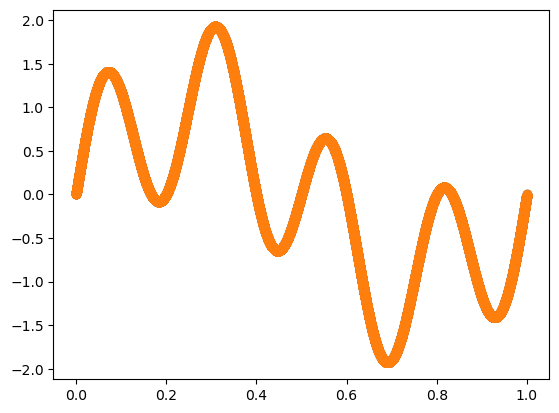

In [1]:
import numpy as np
import matplotlib.pyplot as plt
nax = np.newaxis

# input function
n_x = 1024
x = np.linspace(0, 1, n_x)
a = np.sin(2 * np.pi * x) + np.sin(8 * np.pi * x)

fig, ax = plt.subplots()
ax.scatter(x, a)

# Fourier transform
n_f = 128
f = np.arange(n_f)
norm = np.sqrt(n)
DFT = 1 / norm * np.exp(-2*np.pi*1j*f[:,nax]*x[nax,:]).T
Y = DFT @ y

# inverse Fourier transform
IDFT = 1 / norm * np.exp(2*np.pi*1j*x[:,nax]*f[nax,:]).T
yp = IDFT @ Y

# reconstructed signal
ax.scatter(x, yp)